In [208]:
import cv2
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps, ImageShow
import numpy as np
from numpy import ndarray


In [209]:
def read_image_as_numpy_array(image_path, grey_only: bool = True) :
    with Image.open(image_path) as image:
        image = image.convert("L") if grey_only else image 
        np_image = np.array(image)
        return np_image

In [210]:
import pathlib
current_dir = pathlib.Path.cwd()
image_file = str(pathlib.Path.joinpath(current_dir,"Lenna.png"))

In [211]:
def show_image(image, grey_only = True):
    #greys = ["Greys_r", "Greys_g", "Greys_b"]
    plt.figure(figsize=(25,20))
    for i in range( 1 if grey_only else 3):
        plt.subplot(2,3, i +1)
        plt.title(f"Channel: {i}")
        channel = image[:,:] if grey_only else image[:,:,i]
        plt.imshow(channel, "Greys_r")

from typing import List
def show_image_side_by_side(images: List[ndarray], main_fig_size = (25,20) ):
    plt.figure(figsize=main_fig_size)
    for i in range( len(images) ):
        plt.subplot(1,len(images), i +1)
        plt.title(f"Image: {i}")
        channel = images[i]
        plt.imshow(channel, "Greys_r")

def show_image_histogram(image, grey_only = True):
    plt.figure(figsize=(15,5))

    for i in range(1 if grey_only else 3):
        channel = image[:,:] if grey_only else image[:,:,i]
        plt.subplot(1,3,i+1)
        show_histogram(channel, plotColor= 'black',titlePlot=f"Hist Channel {i+1}")

In [212]:
lenna_image = read_image_as_numpy_array(image_file,True)

Display Gray Image

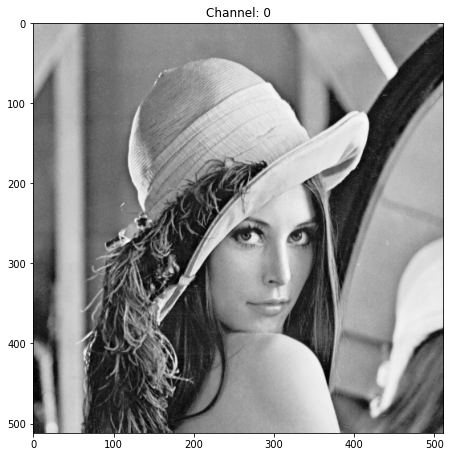

In [213]:
show_image(lenna_image,True)

In [214]:
def show_histogram(input_array, plotColor = 'green' ,num_bins = 255, titlePlot = 'ColorMap', yLabel = 'Freq', xLabel='Intensity') :
   
     input_array = input_array.reshape( (-1,1))
     n, bins, patches = plt.hist(input_array, num_bins, cumulative=False,
                              density = False, 
                              color = plotColor,
                              alpha = 0.7)
     plt.xlabel(xLabel)
     plt.ylabel(yLabel)

     plt.title(titlePlot, fontweight ="bold")

Histogram for Gray Level freq distribution

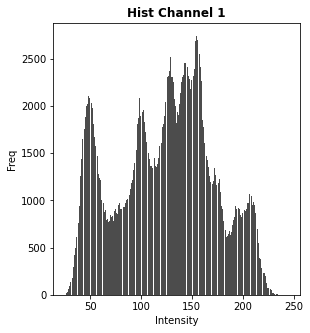

In [215]:
show_image_histogram(lenna_image)

Equalized Histogram for dark image

In [216]:
# assumes gray scale image as input
def equalized_image(input_image: ndarray):
    histogram_array = np.bincount(input_image.flatten(), minlength=256)
    #normalized histogram
    total_pixels = np.sum(histogram_array)
    histogram_array = histogram_array/total_pixels

    #cumulative histogram
    chistogram_array = np.cumsum(histogram_array)

    # (L-1)*cdf
    transform_map = np.floor(255 * chistogram_array).astype(np.uint8)

    # collect pixels of input image and transform values to equalize
    image_pixels = list(input_image.flatten())
    matched_pixels = [transform_map[p] for p in image_pixels]

    # reshape
    transformed_image = np.reshape(np.asarray(matched_pixels), input_image.shape)
    return transformed_image

def display_dark_image_and_histogram(dark_image):
    dark_copy = np.copy(dark_image)

    show_image(dark_copy,True)
    show_image_histogram(dark_copy, True)

    transformed_dark_image = equalized_image(dark_copy)

    show_image(transformed_dark_image,True)
    show_image_histogram(transformed_dark_image, True)


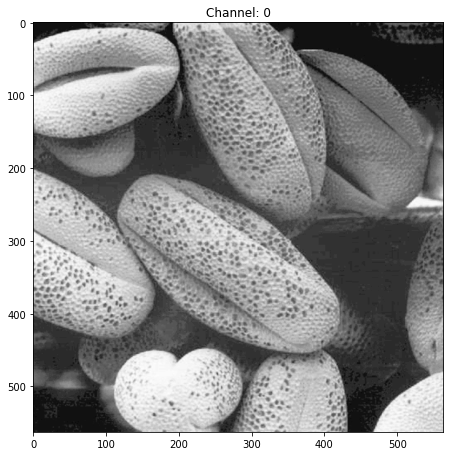

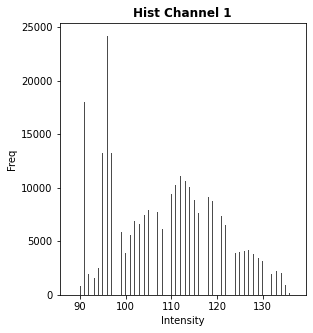

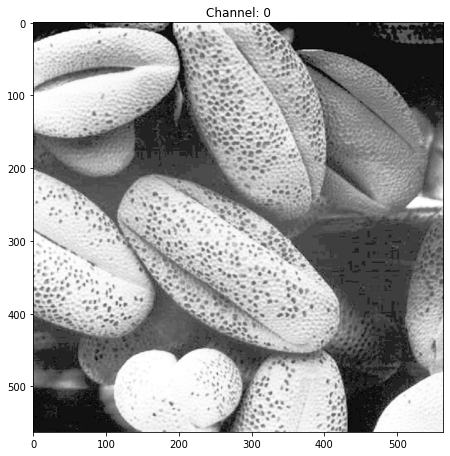

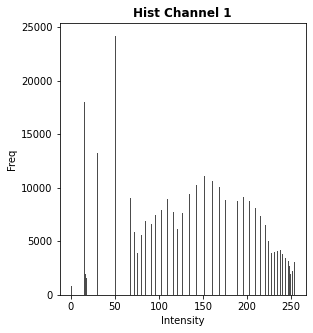

In [217]:
dark_image = read_image_as_numpy_array("dark_image.png")
display_dark_image_and_histogram(dark_image)

Inverted Image Plot

In [218]:
def invert_image(image_2d_array):
    inverted_image = 255 - image_2d_array
    return inverted_image

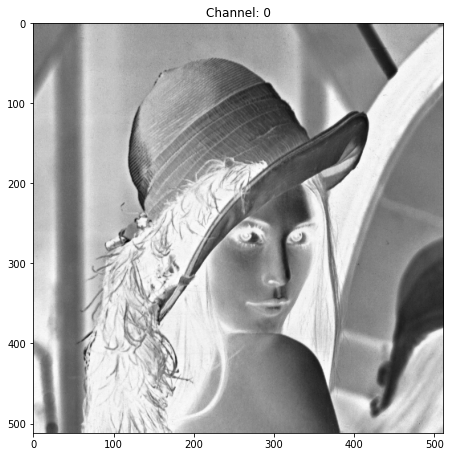

In [219]:
lenna_image_inverted = invert_image(lenna_image)
show_image(lenna_image_inverted)

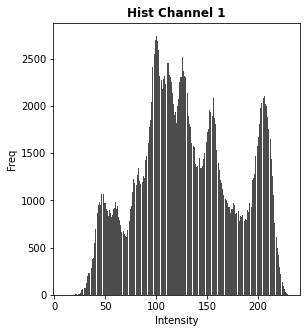

In [220]:
show_image_histogram(lenna_image_inverted)

(512, 512)


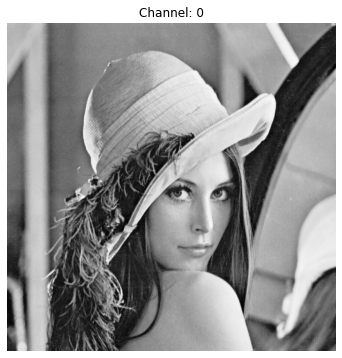

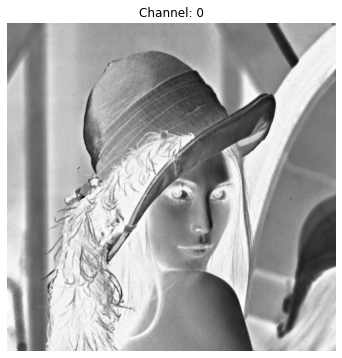

In [221]:
from typing import Callable
from functools import partial
from numpy import ndarray

def execute_custom_operation( input_lambda, subplot_row=1, subplot_column =3, grey_only = True):
    plt.figure( figsize=(20,10) )

    for i in range(1 if grey_only else 3):
        plt.subplot( subplot_row, subplot_column, i+1)
        input_lambda(i)

def figure_channel_wrapper(index, lambda_to_execute):
    plt.title(f"Channel: {index}")
    lambda_to_execute(index)
    plt.axis("off")

def plot_channel(channels: ndarray, index: int,grey_only = True):
    channel_copy = np.array(channels, copy=True)

    figure_channel_wrapper( index, lambda x:
                plt.imshow(channel_copy[:,:] if grey_only else channel_copy[:,:,index],cmap='Greys_r')
            )

def plot_inverted_channel(channels: ndarray, index: int,grey_only = True) -> None:
    channel_copy = np.array(channels, copy=True)

    def invert_and_show(index):
        inverted_data = invert_image(channel_copy[:,:] if grey_only else channel_copy[:,:,index])
        print(inverted_data.shape)
        plt.imshow(inverted_data, cmap='Greys_r')

    figure_channel_wrapper( index, (lambda x: 
                invert_and_show(x)
            )
        )

channel_plot = partial(plot_channel, channels = lenna_image)
channel_inverted_plot = partial(plot_inverted_channel, channels = lenna_image)

execute_custom_operation( lambda x: channel_plot(index=x), subplot_row=1 )
execute_custom_operation( lambda x: channel_inverted_plot(index=x), subplot_row=1 )

Spatial Filter(Linear + Non Linear)

In [222]:
# assume 3x3 filter
import numpy as np
def manipulate(image_array, x_index, y_index, execute):
    a = image_array
    i,j = x_index, y_index

    input_array = [ a[i-1, j-1] , a[i, j-1] , a[i+1,j-1]
             , a[i-1, j] , a[i, j] , a[i+1,j]
            , a[i-1, j+1] , a[i, j+1] , a[i+1,j+1]
            ]

    return execute(input_array)

    # return int(np.sum(input_array)/len(input_array))

    # result: np.int16 = (a[i-1, j-1] + a[i, j-1] + a[i+1,j-1]
    #          + a[i-1, j] + a[i, j] + a[i+1,j]
    #         + a[i-1, j+1] + a[i, j+1] + a[i+1,j+1]
    #         )
    # return int(result/9)

def max_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.max(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def min_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.min(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def median_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.median(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def avg_pixel(image_array, x_index, y_index):
    averager = lambda arr : int(sum(arr)/len(arr))
    return manipulate(image_array, x_index, y_index,averager)

def filter_out(image_array, filter_operation):
    width,height = image_array.shape
    
    for i in range(1,width-1):
        for j in range(1,height-1):
            image_array[i,j] = filter_operation(image_array, i, j)

In [223]:
import time
import os
def plot_with_filter(channels: ndarray, index: int,filter_opeartor, should_invert_image:bool = False, grey_only = True) -> None:
    channel_copy = np.array(channels, copy=True)
    def invert_filter_and_show(index):
        if should_invert_image:
            inverted_data = invert_image(channel_copy[:,:] if grey_only else channel_copy[:,:,index])
        else:
            inverted_data = channel_copy[:,:] if grey_only else channel_copy[:,:,index]
        filter_out(inverted_data, filter_opeartor)
        plt.imshow(inverted_data, cmap='Greys_r')

        #plt.imsave( f"{time.time()}.jpg", inverted_data)

    figure_channel_wrapper( index, (lambda x: 
                invert_filter_and_show(x)
            )
        )


Max Filter on Inverted

In [224]:
inverted_filter = partial(plot_with_filter, channels = np.copy(dark_image),should_invert_image=True)




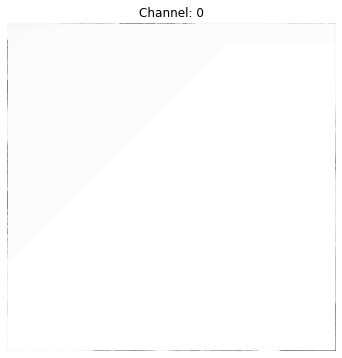

In [225]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=max_pixel), subplot_row=1 )


Min Filter on Inverted



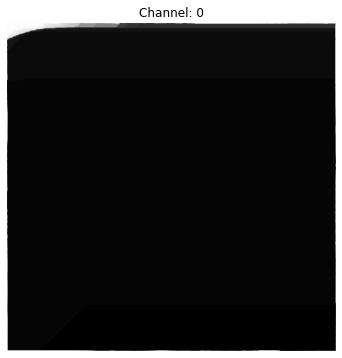

In [226]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=min_pixel), subplot_row=1 )


Median Filter on Inverted Image

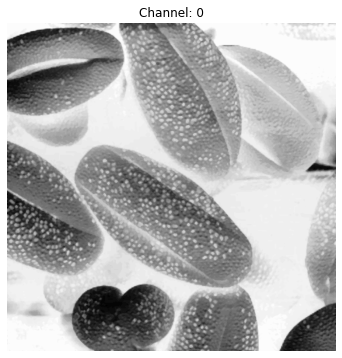

In [227]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=median_pixel), subplot_row=1 )


Avg Filter on Inverted Image

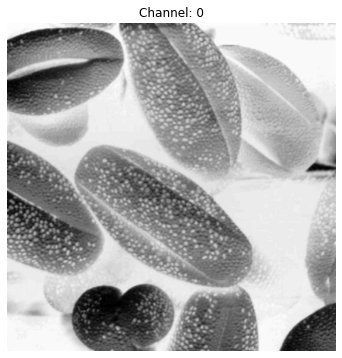

In [228]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=avg_pixel), subplot_row=1 )


In [229]:
# array1 = np.array([ [5,3,4, 5, 2], [15,3,4, 25, 2], [5,3,4, 255, 2], [15,73,4, 5, 21]  ] )
# array1.shape

# dummy1 = np.array( [ [10,20, 30], [5,5,100], [60,50, 30] ])
# dummy1 = array1
# filter1 = np.array( [ [0,-1, 0], [-1,4,1], [0,-1, 0] ])
# filter1 = np.array( [ [1,1, 1], [1,1,1], [1,1, 1] ])
# filter1.shape, dummy1.shape

In [230]:
#dummy1 * filter1, np.sum(dummy1*filter1)

In [231]:
# image_size = dummy1.shape 
# filter_size = filter1.shape

In [232]:
# image_size, filter_size

In [233]:
# #dummy1.reshape(-1,1), filter1.reshape(-1,1)
# print(dummy1)
# print("*********")
# dummy1[3, 1::1]

In [234]:
# print(dummy1.strides)
# dummy1[0:3, 2:4:1]

In [235]:
# filter1.shape

In [236]:
from typing import Callable
FilterCallback = Callable[ [ndarray, ndarray, int], int ]

def convolution(input: ndarray, filter: ndarray, callback: FilterCallback ):
    height, width = input.shape
    filter_height, filter_width = filter.shape
    # pad zero to input array
    stack = np.hstack( [np.zeros( (height,1),dtype=int ) , np.copy(input), np.zeros( (height,1),dtype=int )]  )
    stack2 = np.vstack( [ np.zeros( (1, width + 2),dtype=int ) ,stack, np.zeros( (1, width + 2), dtype=int )])

    buffer = np.zeros( shape=(height, width),dtype=int )

    for h in range(0,height):
        for w in range(0, width): 
            snap = stack2[h: h + filter_height, w: w + filter_width]
            result = callback(snap, filter, input[h,w])
            buffer[h,w] = result
    return buffer

def pointwise_multiply_and_add(x: ndarray, y: ndarray, current: int):
    r =  int((np.sum(x*y)))
    return 255 if r >= 255 else r

def pointwise_multiply_and_add_binarization(x: ndarray, y: ndarray, current: int):
    r =  int((np.sum(x*y)))
    return 255 if r >= 20 else 0

def pointwise_multiply_and_average(x: ndarray, y: ndarray, current: int):
    r =  int( (np.sum(x*y))/ (y.shape[0] * y.shape[1]) )
    return 255 if r >= 255 else current



Weighted Average Filter

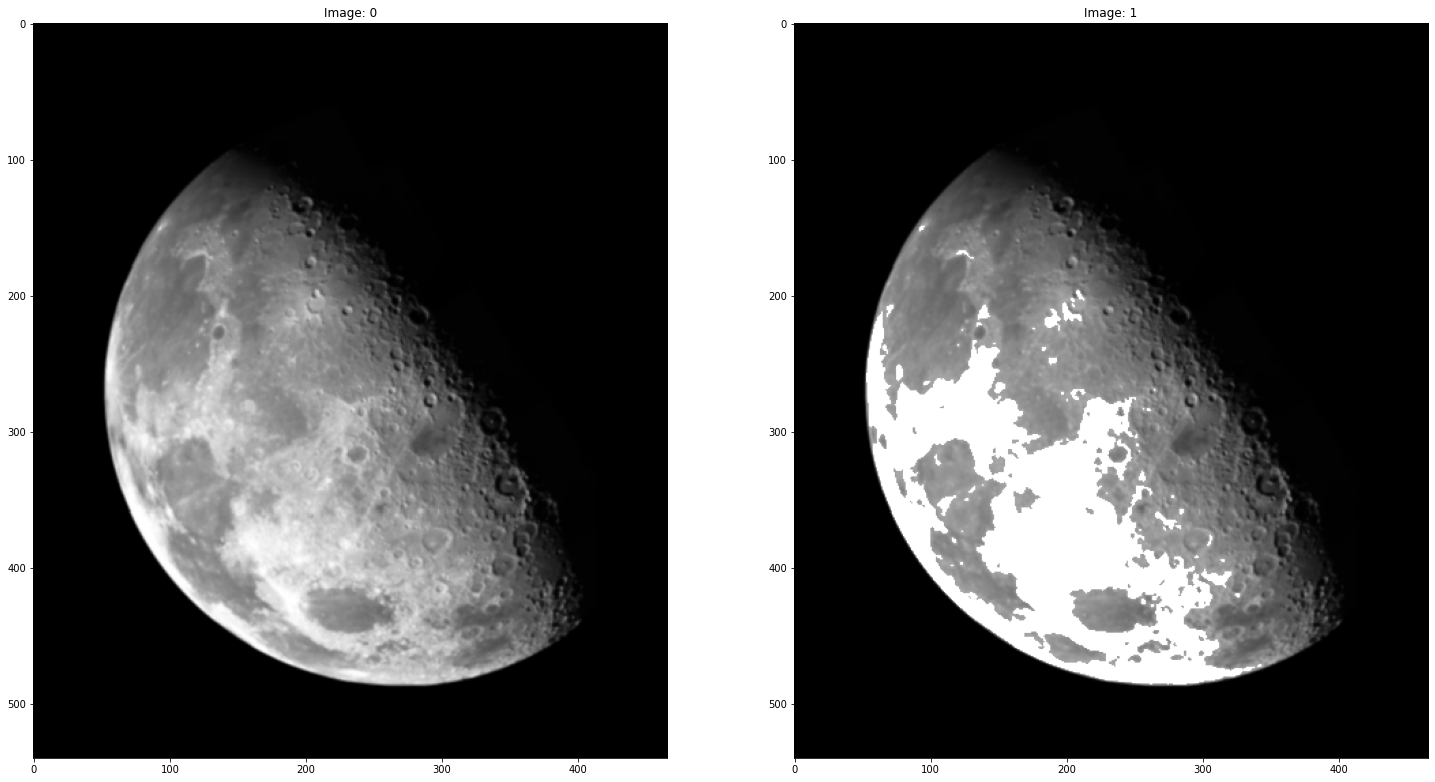

In [237]:
dark_image = read_image_as_numpy_array("blurry_moon.tif",True)
copied_array = np.copy(dark_image[:,:])
weighted_avg_filter = np.array( 
[ 
    [1, 2, 1], 
    [2, 4, 2], 
    [1, 2, 1] 
] )

#show_image(copied_array,True)


conv_result = convolution(copied_array, weighted_avg_filter, pointwise_multiply_and_average)

show_image_side_by_side([copied_array, conv_result])

#show_image_histogram(copied_array, True)
#show_image_histogram(conv_result, True)


Laplacian Filter(Spatial Domain)

In [238]:
blurry_moon = read_image_as_numpy_array("blurry_moon.tif",True)

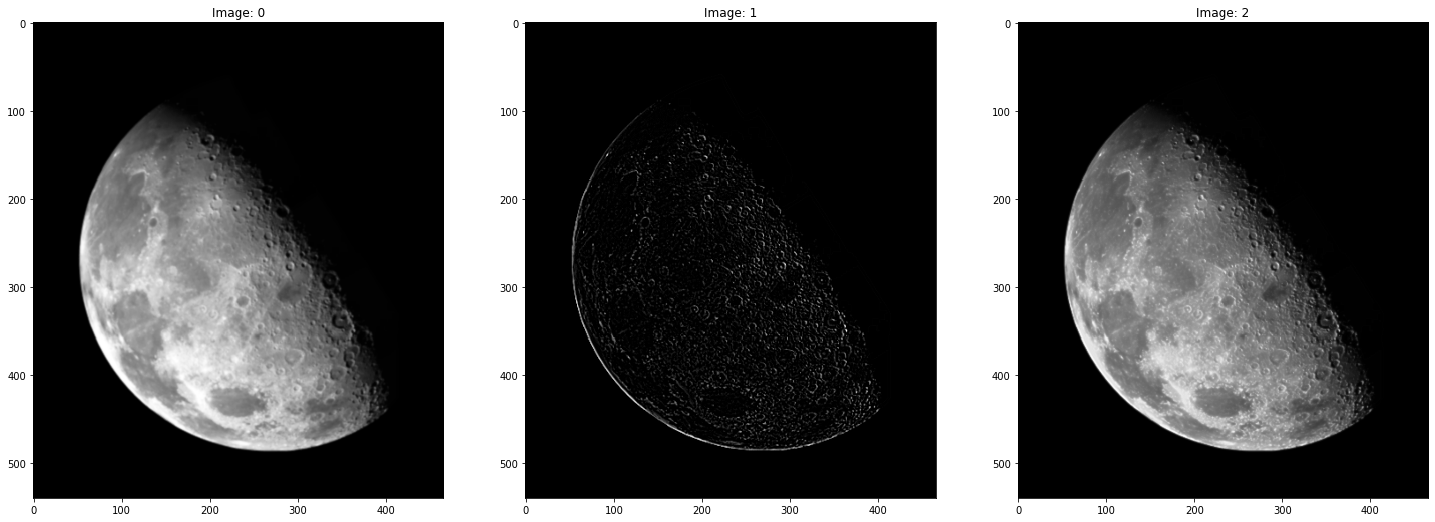

In [239]:
copy_moon = np.copy(blurry_moon)
#show_image(copy_moon, True)

def get_laplacian_filter_and_operator():
    lap_filter = np.array( 
    [ 
        [0, 1, 0], 
        [1, -4, 1], 
        [0, 1, 0] 
    ] )

    def pointwise_multiply_and_add(x: ndarray, y: ndarray, current: int):
        r =  int((np.sum(x*y)))
        # Sanjeev sir comment
        # -ve value in middle of filter causes more -vg result
        # so take abs value when negative and discard +ve value 
        return 0 if r >= 0 else abs(r)

    return (lap_filter, pointwise_multiply_and_add)

conv_result = convolution(copy_moon, *get_laplacian_filter_and_operator() )

# add filter to original image since -ve value is used in middle of filter
show_image_side_by_side([copy_moon,conv_result, copy_moon+conv_result])


Enhanced Laplacian


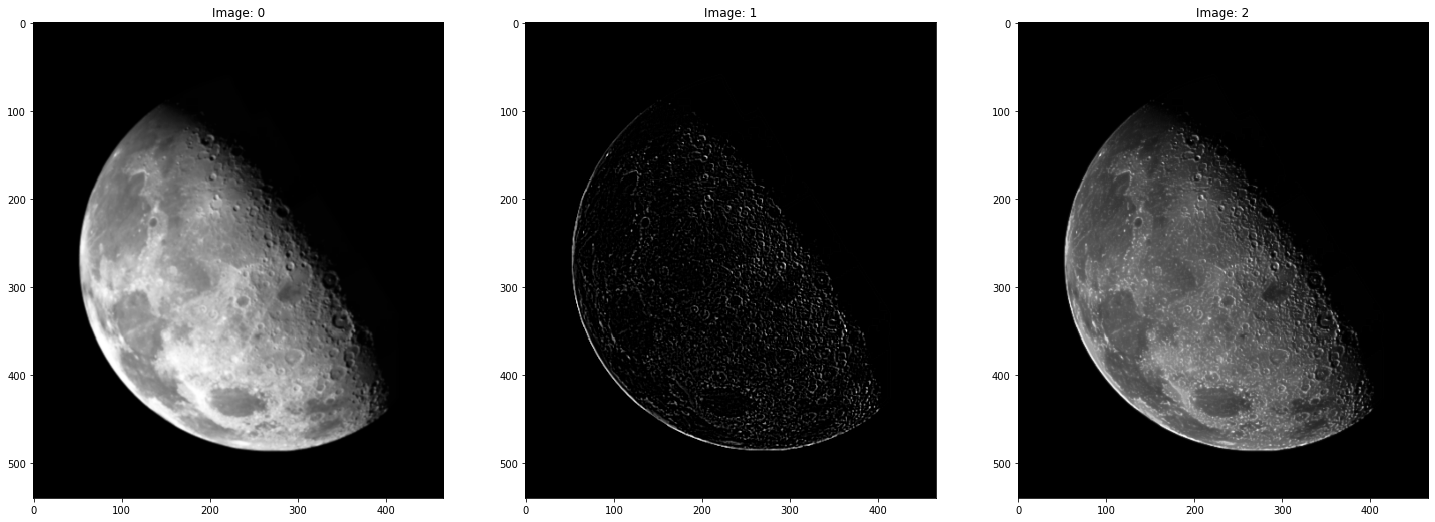

In [240]:
def get_enhanced_laplacian_filter_and_operator():
    enhanced_laplacian_filter = np.array( 
    [ 
        [1, 1, 1], 
        [1, -8, 1], 
        [1, 1, 1] 
    ] )

    def pointwise_multiply_and_add(x: ndarray, y: ndarray, current: int):
        r =  int((np.sum(x*y)))
        # Sanjeev sir comment
        # -ve value in middle of filter causes more -vg result
        # so take abs value when negative and discard +ve value 
        return 0 if r >= 0 else abs(r)
        #return 255 if r >= 255 else r

    return (enhanced_laplacian_filter, pointwise_multiply_and_add) 

copy_moon = np.copy(blurry_moon)

conv_result2 = convolution(copy_moon, *get_enhanced_laplacian_filter_and_operator() )

# add filter to original image since -ve value is used in middle of filter
show_image_side_by_side([copy_moon, conv_result2, copy_moon + conv_result2])

Directly enhanced filter

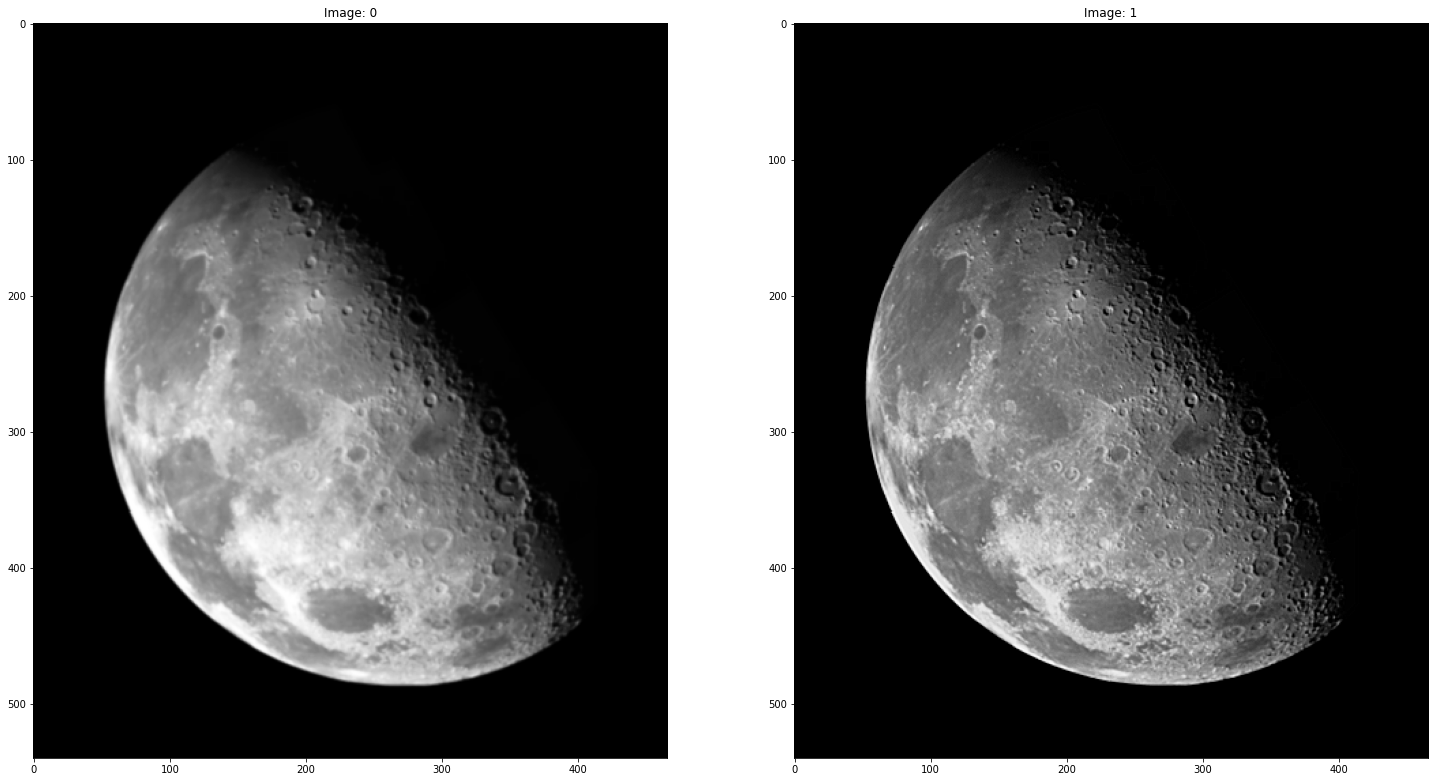

In [241]:
# add filter to original image since -ve value is used in middle of filter
def get_over_laplacian_filter_and_operator():
    over_laplacian_filter = np.array( 
    [ 
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1] 
    ] )

    over_laplacian_filter = np.array( 
    [ 
        [0, -1, 0], 
        [-1, 5, -1], 
        [0, -1, 0] 
    ] )

    def pointwise_multiply_and_add(x: ndarray, y: ndarray, current: int):
        r =  int((np.sum(x*y)))
        return 0 if -r >= 0 else abs(r)

    return (over_laplacian_filter, pointwise_multiply_and_add)

copy_moon = np.copy(blurry_moon)
conv_result3 = convolution(copy_moon, *get_over_laplacian_filter_and_operator() )

show_image_side_by_side([copy_moon, conv_result3])
#show_image_side_by_side([copy_moon, conv_result3, copy_moon + conv_result3])

Sobel


In [242]:
def sobel(input_array: ndarray, horizontal = True):
    sobel_filter = np.array( 
            [ 
                [-1, -2, -1], 
                [0, 0, 0], 
                [1, 2, 1] 
            ] )

    if horizontal == False:
        sobel_filter = np.array( 
            [ 
                [-1, 0, 1], 
                [-2, 0, 2], 
                [-1, 0, 1] 
            ] )


    def sobel_operation(x: ndarray, y: ndarray, current: int):
        r =  int((np.sum(x*y)))
        return 1 if r >= 40 else 0

    return convolution(input_array, sobel_filter, sobel_operation)

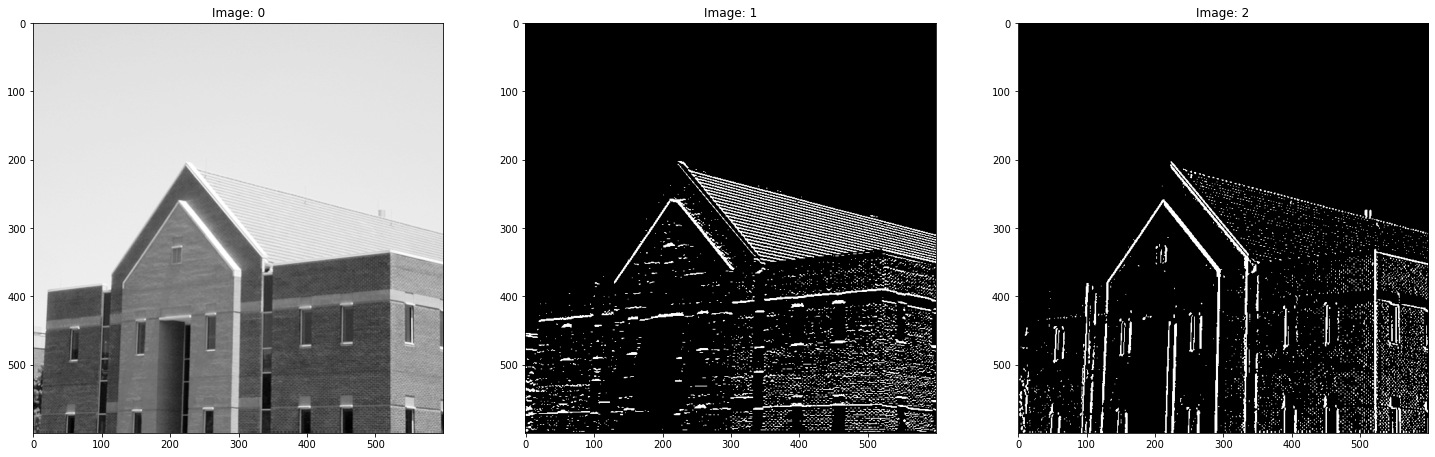

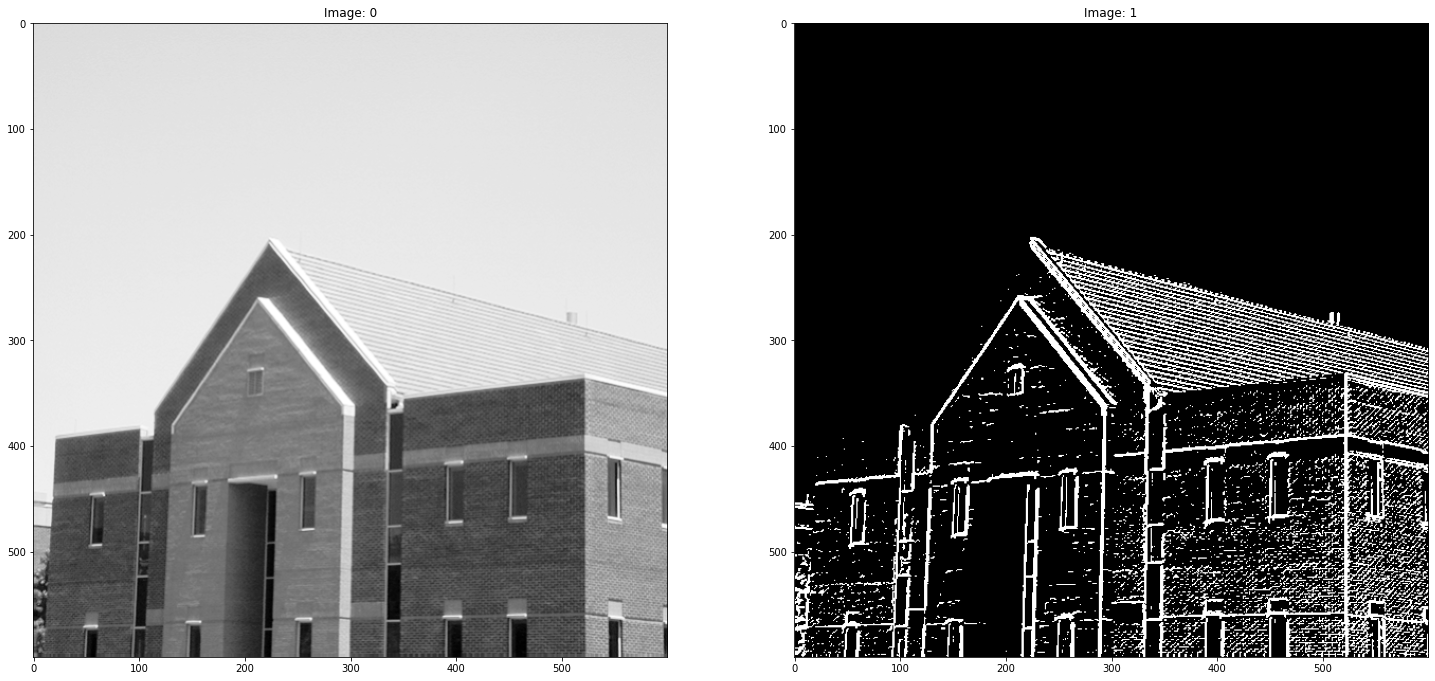

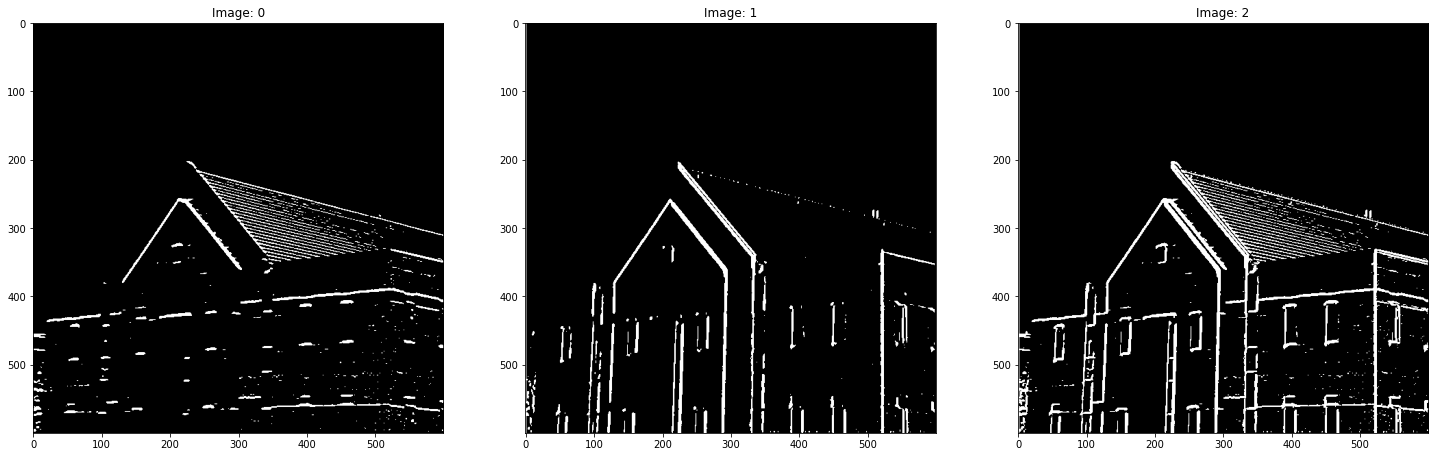

In [243]:
home = read_image_as_numpy_array("home.tif",True)
copy_home = np.copy(home)
#show_image(copy_moon, True)

conv1 = sobel(copy_home)

copy_home = np.copy(home)
conv2 = sobel(copy_home,horizontal=False)

show_image_side_by_side([copy_home, conv1, conv2])

show_image_side_by_side([copy_home, np.maximum(conv1, conv2)])


def sobel_smoothen(input_array: ndarray):
    avg_filter = np.array( 
            [ 
                [1, 1, 1], 
                [1, 1, 1], 
                [1, 1, 1] 
            ] )

    def avg_operation(x: ndarray, y: ndarray, current: int):
        r =  int((np.sum(x*y) )/(y.shape[0]*y.shape[1]))
        return r
    return convolution(input_array, avg_filter,avg_operation)


copy_home = np.copy(home)
smooth = sobel_smoothen(copy_home)

copy_smooth = np.copy(smooth)
smooth_horizontal = sobel(copy_smooth)

copy_smooth = np.copy(smooth)
smooth_vertical = sobel(copy_smooth,horizontal=False)

show_image_side_by_side([smooth_horizontal, smooth_vertical , np.maximum(smooth_horizontal, smooth_vertical)])

In [244]:
# input_array = np.array(range(5))
# input_array = np.linspace(start=-10, stop=10, num=101)

# another_input = input_array + 1j * input_array[:, np.newaxis]
# plt.figure(figsize=(5,5))

# plt.imshow(np.abs(another_input), extent=[-10, 10, -10, 10], cmap='gray')

# fft_result = np.fft.fft(another_input)
# fft_spect = np.abs(fft_result)

# print(fft_result)
# print(fft_spect)

# plt.imshow(np.abs(fft_spect), extent=[-10, 10, -10, 10], cmap='gray')
# # plt.plot(another_input,fft_spect)
# # plt.show()

Frequency Domain(Fourier Transform)

Max spectrum:  816000.0


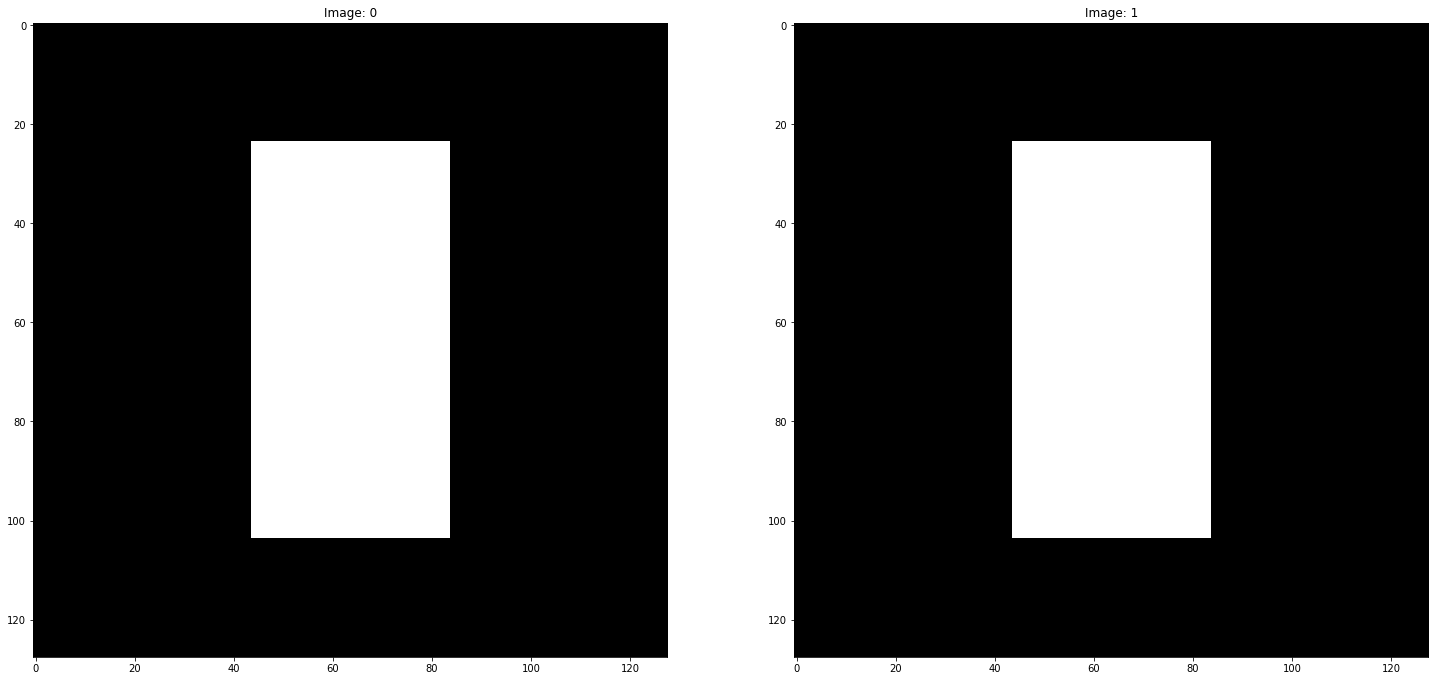

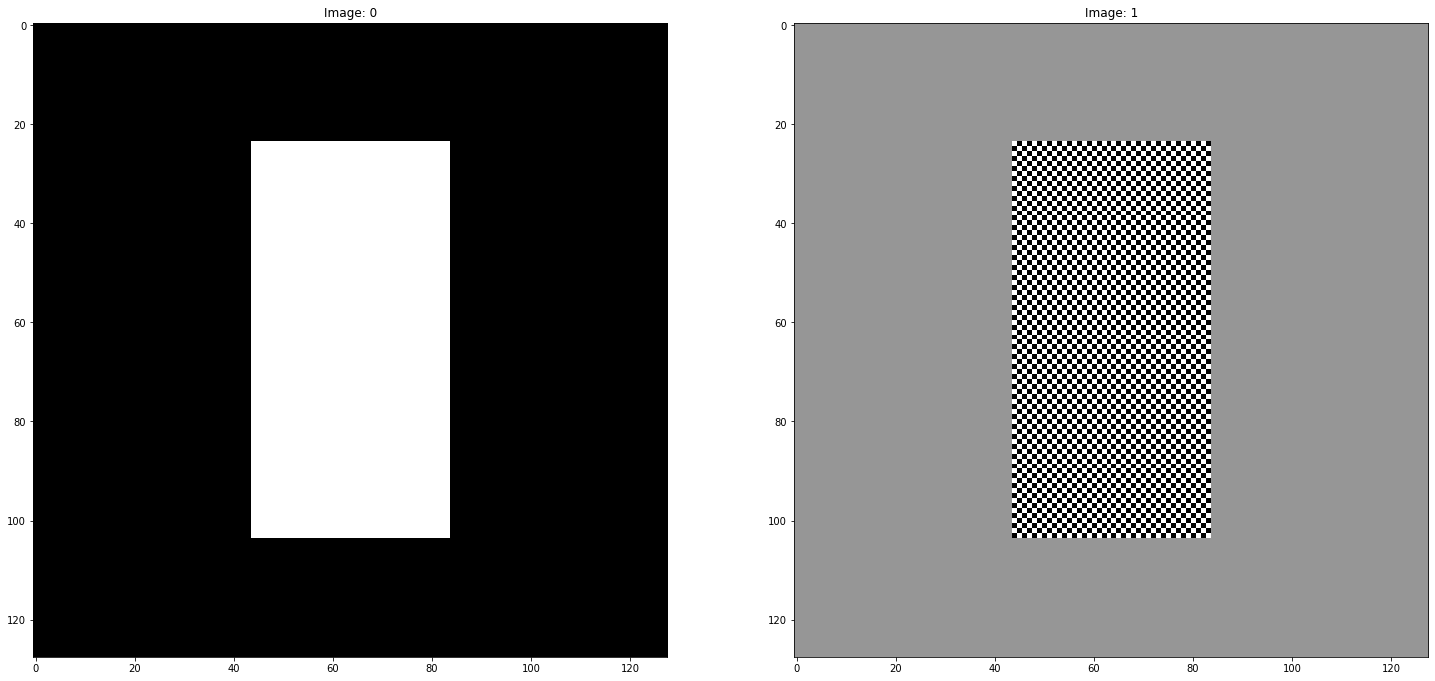

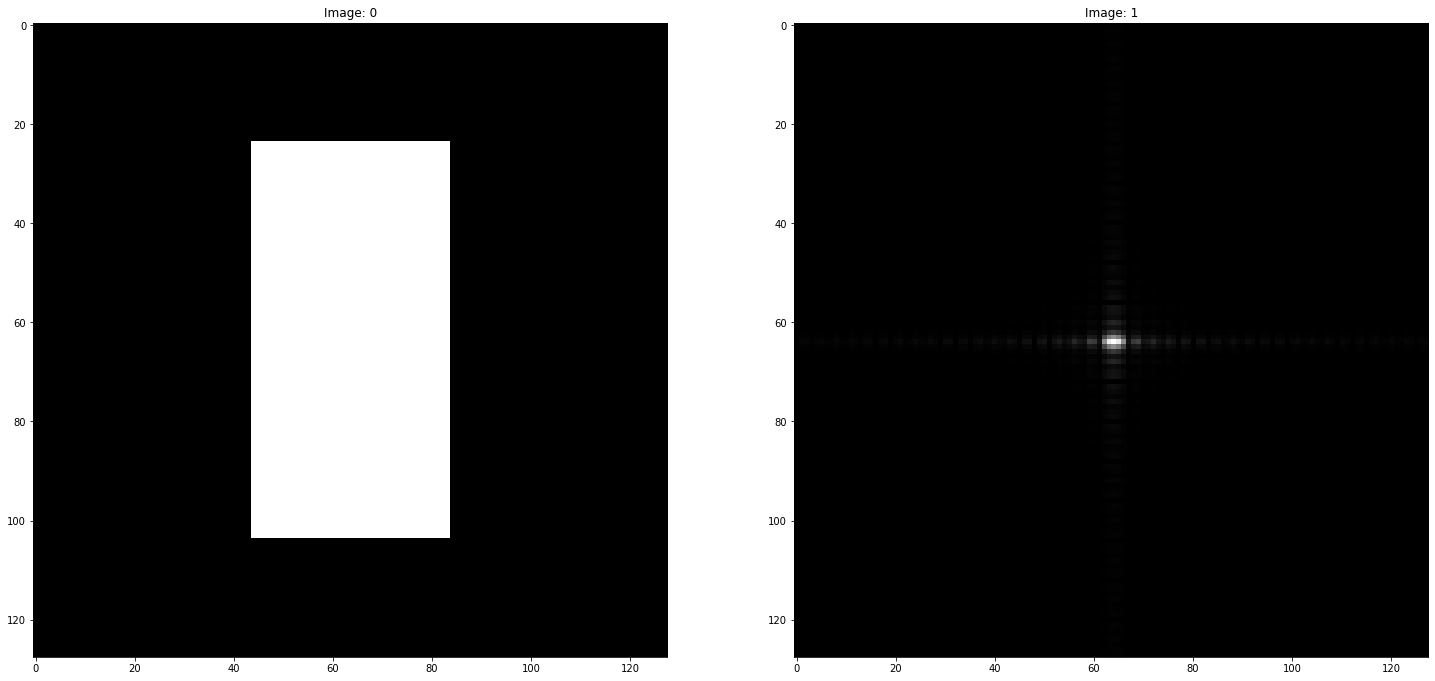

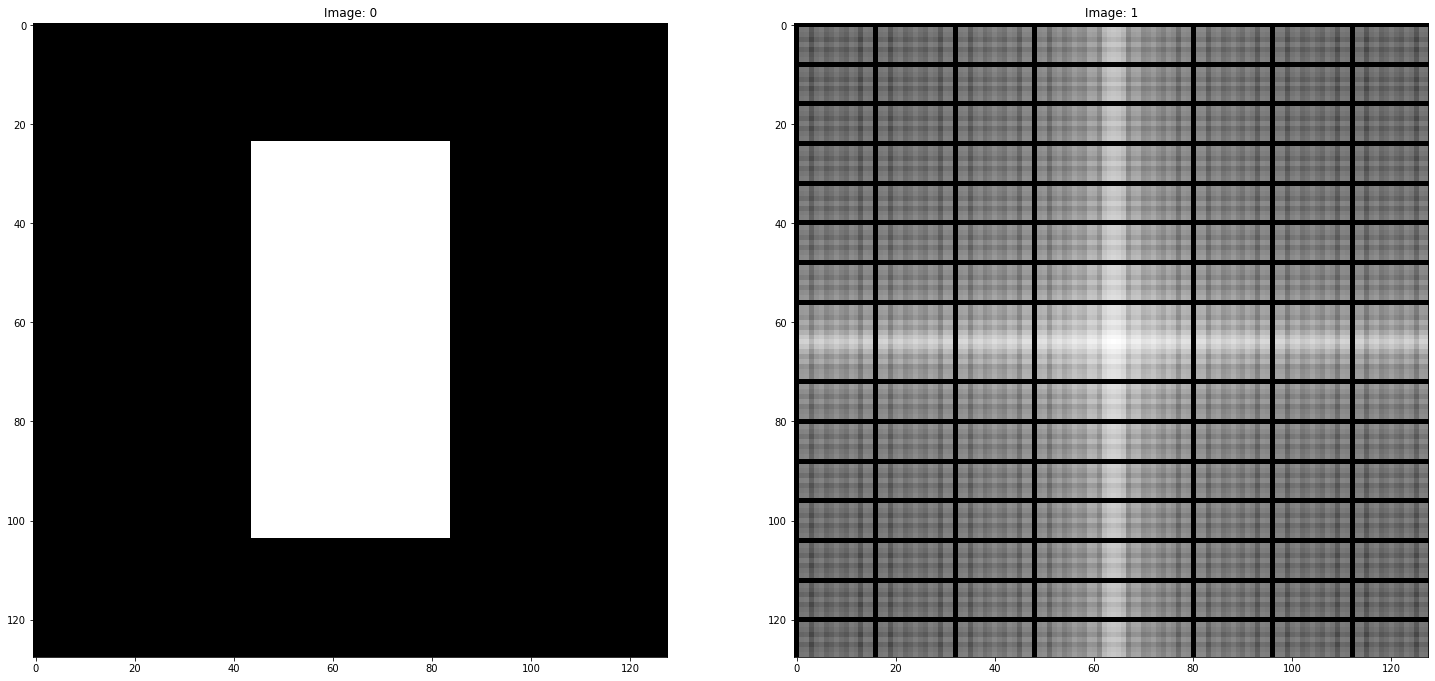

In [245]:
x_size, y_size = 128, 128
original_fourier_image = np.zeros(shape=(x_size,x_size))

# draw white rectangle
xleft_from_center, yleft_from_center = 40,20 
original_fourier_image[64-xleft_from_center:64+xleft_from_center, 64-yleft_from_center:64+yleft_from_center] = 255

fourier_image = np.copy(original_fourier_image)

show_image_side_by_side([original_fourier_image, fourier_image])

# translation of origin
for i in range(x_size):
    for j in range(y_size):
        fourier_image[i,j] = fourier_image[i,j]*(-1)**(i+j)

show_image_side_by_side([original_fourier_image, fourier_image])

# compute 2d fft
two_dimensional_fft = np.fft.fft2(fourier_image)

#print("FFT", two_dimensional_fft)

fourier_spectrum = np.abs(two_dimensional_fft)

#print("spectrum", fourier_spectrum)

max_spectrum = np.max(fourier_spectrum)

print("Max spectrum: ", max_spectrum)

larger_items = fourier_spectrum[np.where(fourier_spectrum >= 50000 )]

#print("Larger items: ", len(larger_items),  larger_items)

# use magnitude to plot fft
show_image_side_by_side([original_fourier_image, fourier_spectrum ])

final_result = np.log(1 + fourier_spectrum)*(255/np.log(1 + max_spectrum ))

show_image_side_by_side([original_fourier_image, final_result ])

# show_image_side_by_side([
#     final_result[64-10:64+10, 64-yleft_from_center: 64+yleft_from_center] ]
#     , main_fig_size=(5,5) )



(540, 466) (540, 466)


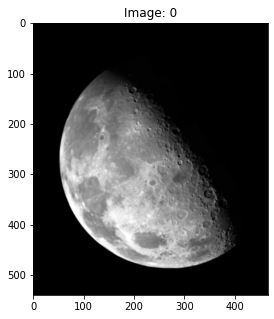

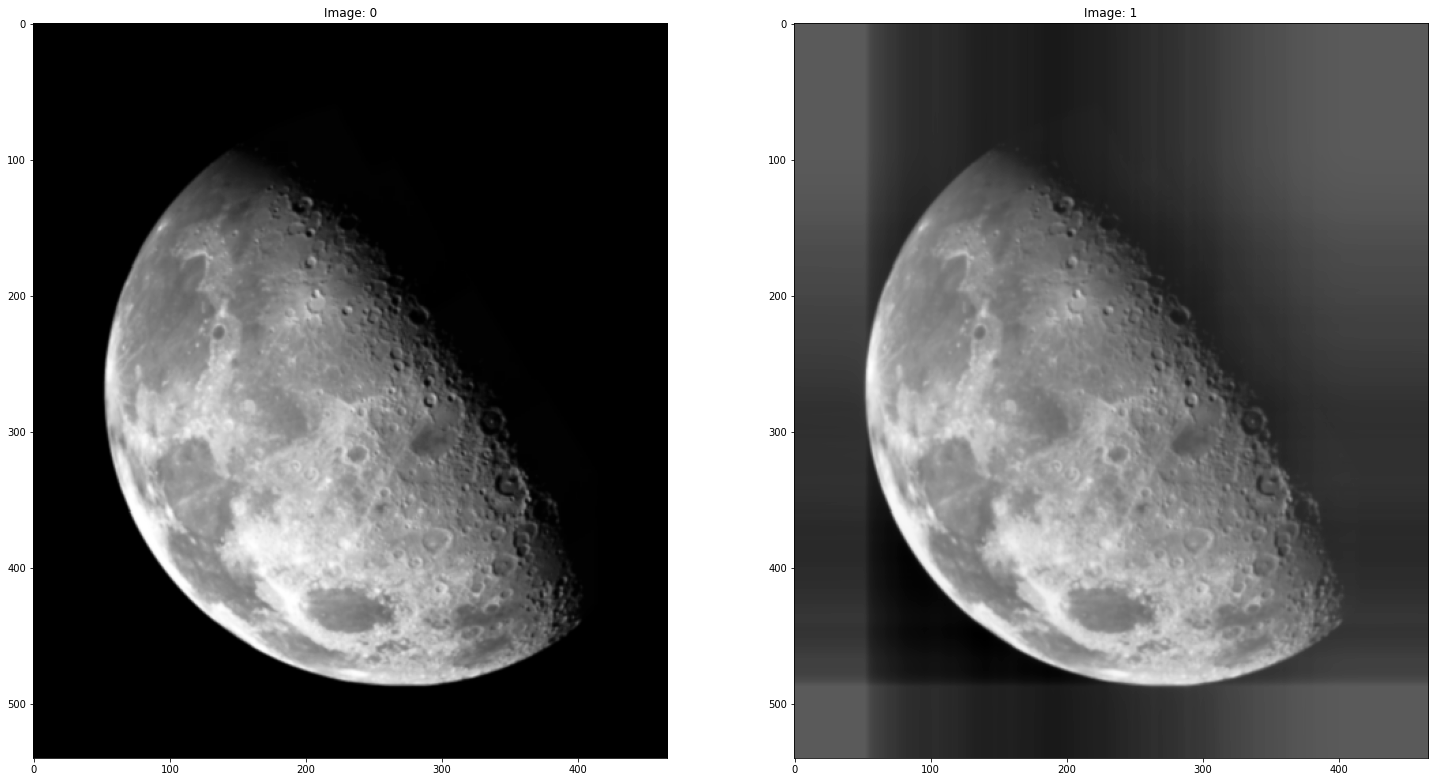

In [247]:

def laplacian_freq_domain(source_image: ndarray): 
    fft_input = np.fft.fft2(source_image)

    fourier_edge = np.zeros(shape=(source_image.shape[0], source_image.shape[1]),dtype= np.complex64 )

    height, width = fourier_edge.shape

    print(source_image.shape, fourier_edge.shape)

    for i in range(height):
        for j in range(width):
            fourier_edge[i,j] = ((2*np.pi)**2 * (i**2 + j**2))*fft_input[i,j]

    laplacian_edge = np.fft.ifft2(fourier_edge)

    spectrum = np.real(laplacian_edge)

    # x = spectrum[np.where(spectrum > 1000000)]
    # print(len(x))

    show_image_side_by_side([source_image, spectrum])

show_image_side_by_side([blurry_moon],main_fig_size=(5,5))
laplacian_freq_domain(blurry_moon)


Filters in freq domain

(540, 466)
(540, 466)
(540, 466)
(540, 466)


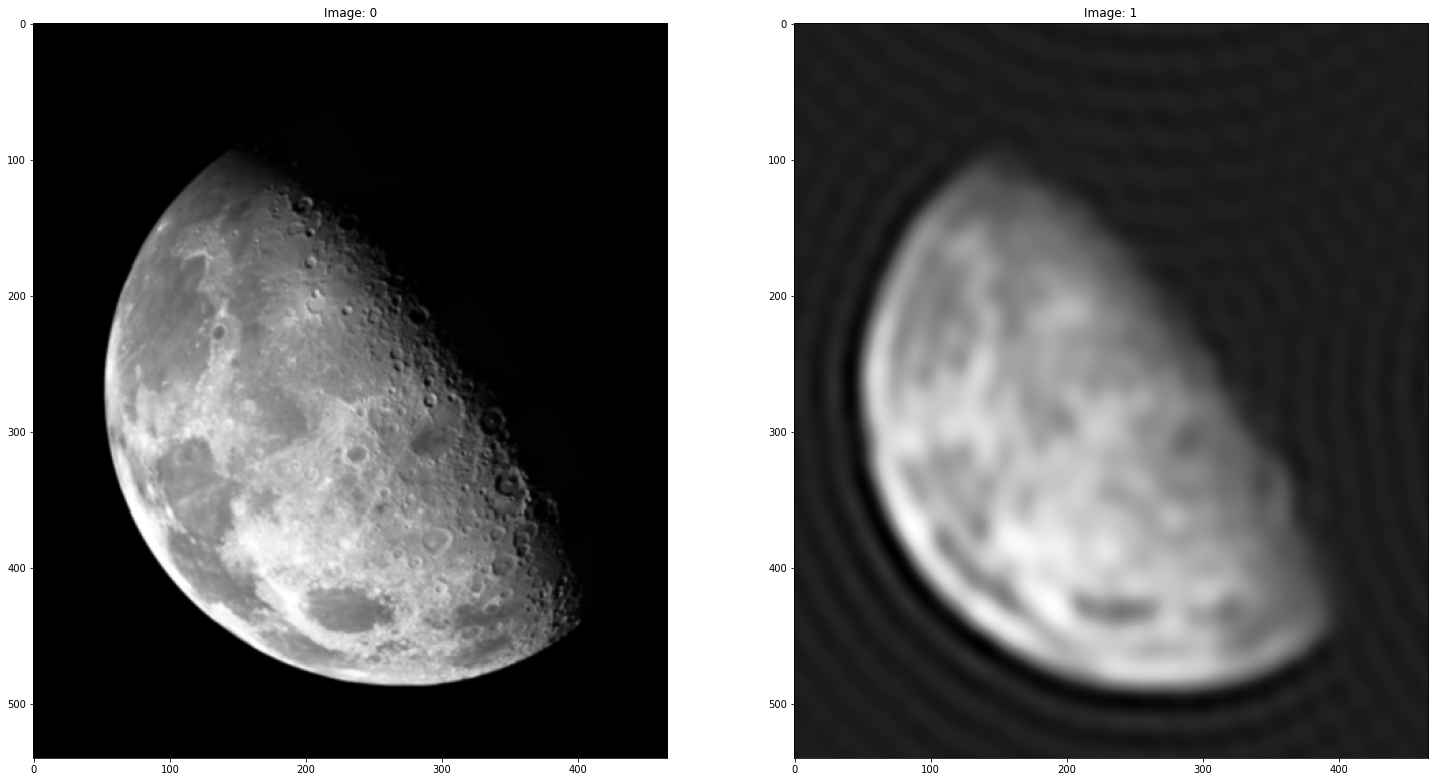

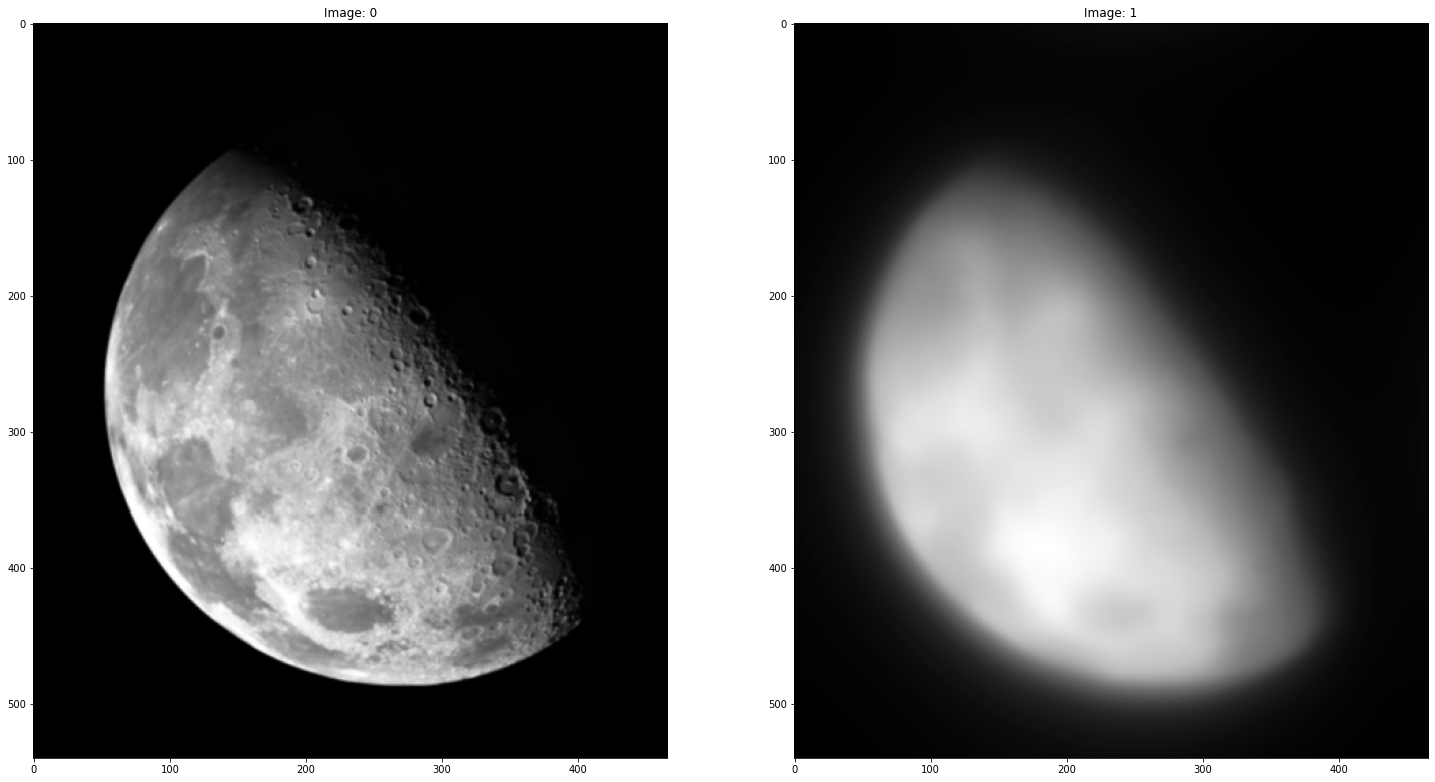

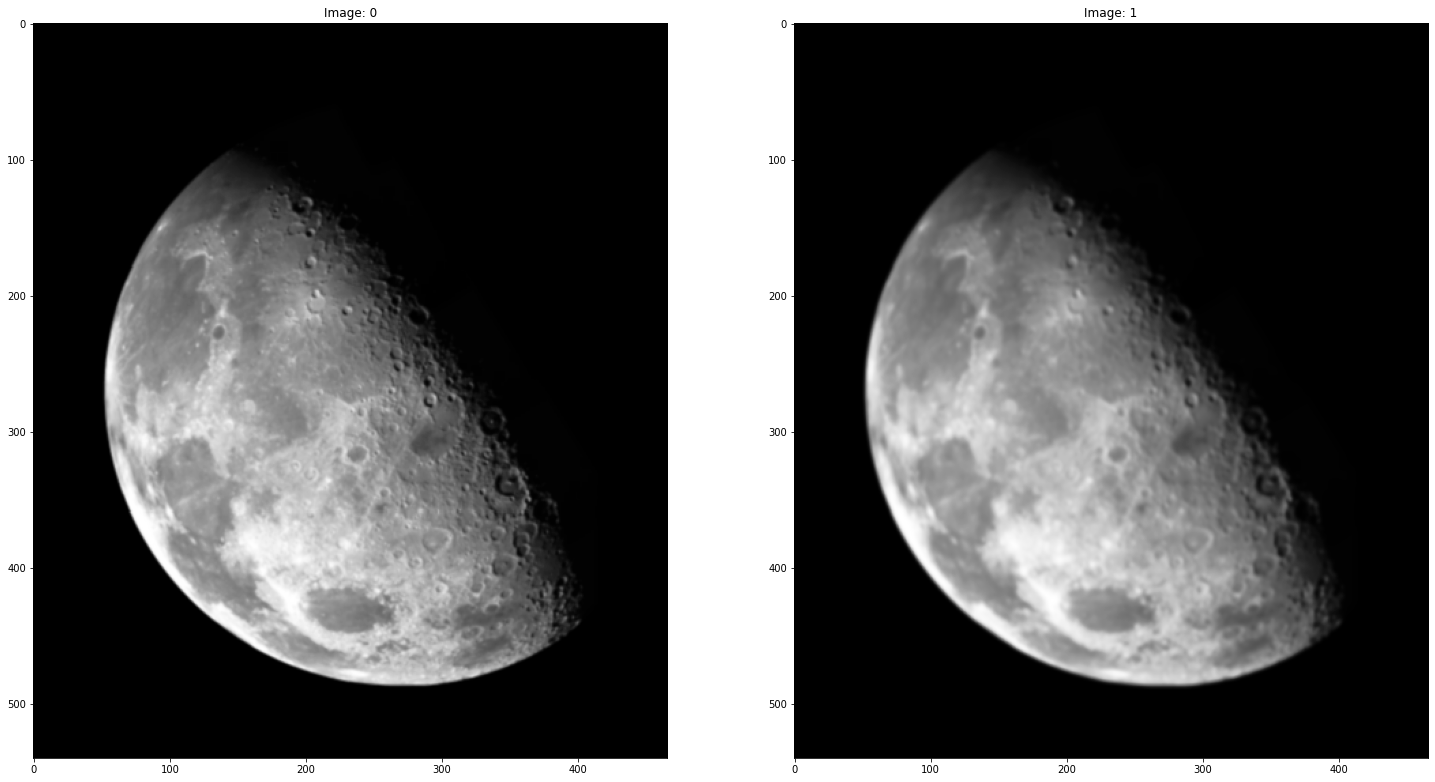

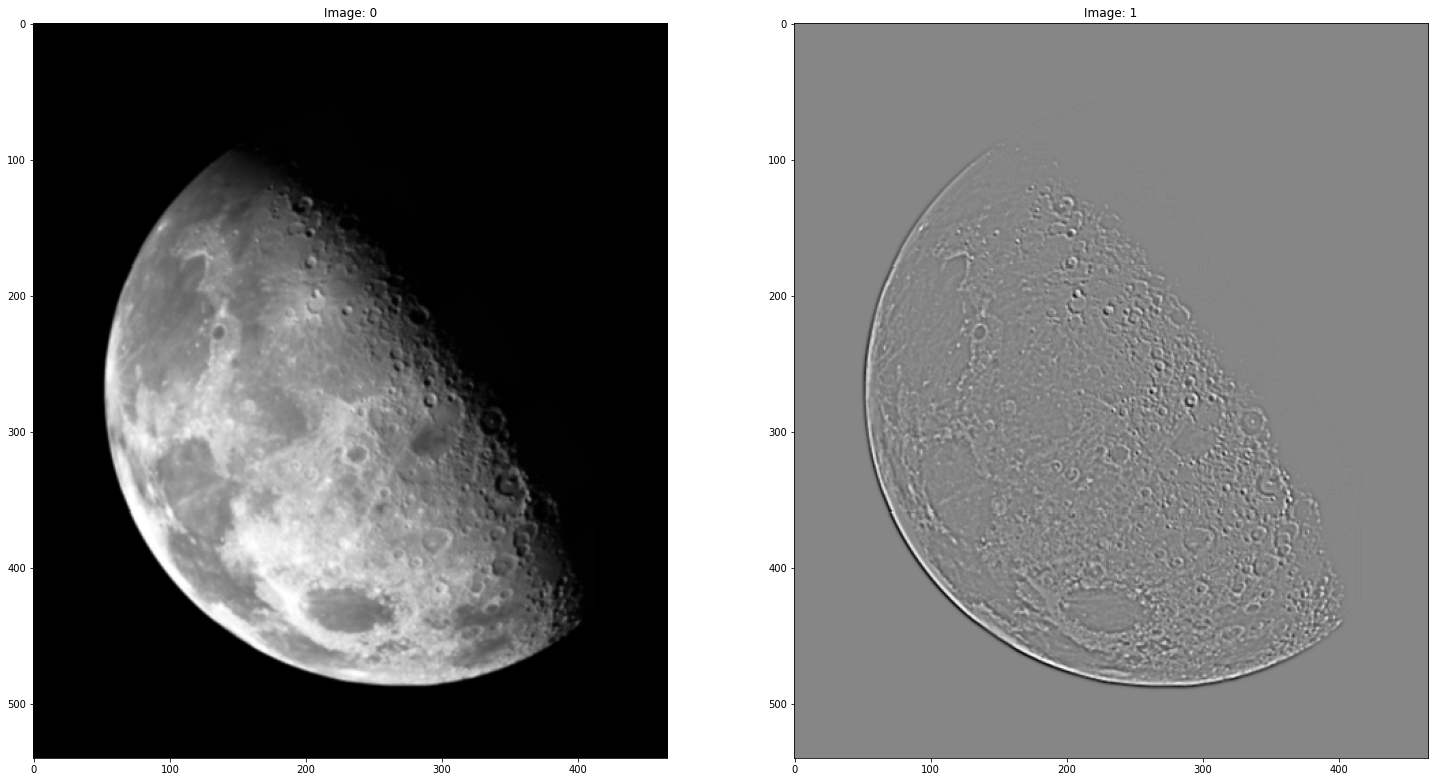

In [277]:
def distance( first: tuple, second: tuple):
    return np.sqrt((first[0] - second[0])**2 + (first[1] - second[1])**2)

from typing import Callable
TransferFunctionCallback = Callable[ [float, float], float ]

def butterworth(distance, cutoff):
    return 1/(1 + distance/cutoff)**(2*2)

def ideal(d: float, threshold: float):
    return 1 if d < threshold else 0

def gaussian(d: float, cutoff: float):
    return np.exp( - d**2 / (2*cutoff)**2 )

def gaussian_highpass(d: float, cutoff: float):
    return 1 - gaussian(d, cutoff)

input_image = np.copy(blurry_moon)

def filter_in_freq_domain(input_image: ndarray, transfer_function_callback: TransferFunctionCallback, threshold: float = 5): 
    # translate to center before fourier transform

    height, width = input_image.shape

    centered_image = np.zeros(shape=(height,width), dtype=np.complex64)

    for i in range(height):
        for j in range(width):
            centered_image[i,j] = (-1)**(i+j)*input_image[i,j]

    print(centered_image.shape)
    # compute fourier transform
    fft_centered = np.fft.fft2(centered_image)


    for i in range(height):
        for j in range(width):
            d = distance( (i,j), (height/2, width/2) )
            response = transfer_function_callback(d, threshold)
            fft_centered[i,j] = fft_centered[i,j] * response #if d < threshold else 0

    ifft_centered  = np.fft.ifft2(fft_centered)

    final_image = np.zeros(shape=(height,width))

    for i in range(height):
        for j in range(width):
            final_image[i,j] = (-1)**(i+j)*np.real(ifft_centered[i,j])

    show_image_side_by_side([ input_image, final_image])

filter_in_freq_domain(input_image, ideal,threshold=20)
filter_in_freq_domain(input_image, butterworth,threshold=20)
filter_in_freq_domain(input_image, gaussian, threshold=50)
filter_in_freq_domain(input_image, gaussian_highpass,threshold=50)
